# The Diffusion Problem
This notebook is an introduction to solving a time-dependent temperature diffusion PDE for a given block of material.  Within the block there is a heat source which drives temperature diffusion. On the surface, energy can radiate into the surrounding environment.
<figure>
    <center>
    <img src="figures/Helmholtz.png", width="400">
    </center>
    <center>
    <caption>The domain $\Omega=[0,l0]\times[0,l1]=\{ (x_0;x_1)~|~0\le x_{0} \le l0 \mbox{ and } 0\le x_{1} \le l1 \}$ for temperature diffusion problem  with heat source.
        </caption></center>
 </figure>
The solution method includes a time integration scheme, the ackward Euler method, and at each step a boundary value problem, the Helmholtz equation, is solved.


## Temperature diffusion equations
The unknown temperature $T$ is a function of its location in the domain and time $t>0$. The governing equation in the interior of the domain is given by
\begin{equation}
\rho c_p \frac{\partial T}{\partial t} - \nabla\cdot(\kappa \nabla T) = q_H
 \tag{1}
\end{equation}
where $\rho c_p$ and $\kappa$ are given material constants. In case of a composite material parameters depend on their location in the domain.
$q_H$ is a heat source (or sink) within the domain.  We assume $q_H$ to be equal to a constant heat production rate $q^{c}$ on a circle or sphere with center $x^c$ and radius $r$, and $0$ elsewhere:
\begin{equation}
q_H(x,t)=\left\{ 
\begin{array}{l l}
    q^c  & \quad\text{if $\|x-x^c\| \le r$}\\
    0    & \quad\text{else}\\
\end{array} \right.
\tag{2}
\end{equation}
for all $x$ in the domain and time $t>0$.

On the boundary of the domain we specify a radiation condition which prescribes the normal component of the flux $\kappa \nabla T$ to be proportional to the difference of the current temperature to the surrounding temperature $T_{ref}$:
\begin{equation}
\mathbf{n}\cdot (\kappa \nabla T) = \eta (T_{ref}-T) 
\tag{3}
\end{equation}
$\eta$ is a given material coefficient depending on the material of the block and the surrounding medium.
$\mathbf{n}$ is the outward normal at the boundary of the domain. 

## Backward Euler
Let $T^{(n)}$ be the temperature at time $t^{(n)}$.  To solve the time-dependent (1), an initial temperature at time $t^{(0)}=0$ has to be given.  For this problem, it is assumed that the initial temperature is the surrounding temperature:
\begin{equation}
T^{(0)}=T_{ref} 
\tag{4}
\end{equation}
for all $x$ in the domain. Note that the initial conditions satisfy the boundary condition defined by (3). The temperature is calculated at discrete time nodes $t^{(n)}$, with $t^{(n)}=t^{(n-1)}+h$, where $h>0$ is the step size, assumed to be constant in this example.  

The simplest and most robust scheme to approximate the time derivative of the temperature is the backward Euler scheme.  It is based on the Taylor expansion of $T$ at time $t^{(n)}$:
\begin{equation}
\frac{\partial T}{\partial t}^{(n)}\approx\frac{T^{(n)}-T^{(n-1)}}{h}
\tag{5}
\end{equation}
Substituting (5) into (1) and rearranging with unknowns on the left and knowns on the right, the time evolution of the temperature is given by

\begin{equation}
- \nabla\cdot(\kappa \nabla T^{(n)}) +\omega T^{(n)}  = q_H +  \omega T^{(n-1)}
\tag{6}
\end{equation}
with 
\begin{equation}
\omega=\frac{\rho c_p}{h}.
\tag{7}
\end{equation}

Together with the natural boundary condition 
\begin{equation}
 \mathbf{n}\cdot (\kappa \nabla T^{(n)}) + \eta T^{(n)}= \eta T_{ref} 
\tag{8}
\end{equation}
taken from (3).  This forms a boundary value problem, the Helmholtz problem, that has to be solved for each time step. 

## Solving The Helmholtz problem
### Step 1. Define the domain.
The function **Rectangle** from *esys-finley* is used to define the domain.  The rectangle used for this example has bottom left corner at $(0,0)$ and top right corner $(5,1)$ with 50 elements in the $x_0$ direction and and 10 elements in the $x_1$ direction.  The commands for creating the domain are   

In [1]:
from esys.finley import Rectangle
mydomain = Rectangle(l0=5., l1=1., n0=50, n1=10)

### Step 2.  Define the PDE and boundary conditions, solve, and output
The PDE is defined using the [**LinearPDE**](LINK) class. This is just a simple example and more details on the class can be found in [**LinearPDE**](LINK). Undefined coefficients in the LinearPDE class are assumed to not be present.  The format of the PDE for the Helmholtz case is 
\begin{equation}
-\nabla\cdot(\mathbf{A}\nabla u) + Du = Y 
\tag{9}
\end{equation}



For a 2D single PDE, $\mathbf{A}$ is a $2\times 2$, rank 2 Data object.  For the Helmholtz case,
\begin{equation}
\mathbf{A}=\begin{pmatrix}\kappa & 0\\ 0 & \kappa\end{pmatrix} 
\end{equation}
$\mathbf{A}$ is symmetric and setting this in the implementation as part of the LinearPDE class.

The other coefficients are scalars,
\begin{equation}
D = \omega = \frac{\rho c_p}{h}\quad \mbox{and}\quad Y = f = q_H +\omega T^{(n-1)}
\end{equation}

For the boundary conditions, the linear single PDE format is 
\begin{equation}
\mathbf{n}\cdot (\mathbf{A}\nabla u) +du = y
\end{equation}
with $\mathbf{A}$ from (9).  The additional coefficients are
\begin{equation}
d=\eta \quad\mbox{and}\quad y= \eta T_{ref}
\end{equation}

To define coefficient $\mathbf{A}$, we use the *esys-escript* **kronecker** function, 
\begin{equation}
\delta_{ij}=\left\{ 
\begin{array}{l l}
    1  & \quad\text{if } i=j\\
    0    & \quad\text{otherwise}\\
\end{array} \right.
\end{equation}

In [2]:
from esys.escript import kronecker
print("kronecker(2)=\n",kronecker(2))

kronecker(2)=
 [[1. 0.]
 [0. 1.]]


The outward normal on the domain is required to apply the boundary conditions. This is a property of the **Domain**class.

In [3]:
n=mydomain.getNormal()

To test the implementation, we solve the Helmholtz equation on a rectangular domain of length $l_{0}=5$ and height $l_{1}=1$.  We choose a simple test solution such that we can verify the returned solution against the exact answer. For this we assume $T=x_{0}$ (with
$q_H = 0$) and then calculate right hand side terms $\omega T^{(n-1)}$ and $\eta T_{ref}$ such that the test solution becomes the solution of the problem. If we assume $\kappa$ is constant, an easy calculation shows that we have to choose $\omega T^{(n-1)}=\omega x_{0}$.
On the boundary we get $\eta T_{ref} = \kappa n_0+\eta x_0$.  The result is displayed using matplotlib, but could easily be exported as a silo or vtu file.

error is  4.2238301745101126e-09


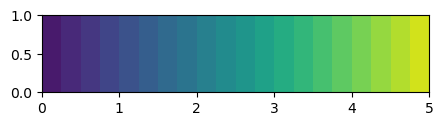

In [4]:
from esys.escript import *
from esys.escript.linearPDEs import LinearPDE
from esys.finley import Rectangle
from scipy.interpolate import griddata
import numpy as np
from matplotlib import pyplot as plt

# set some parameters
kappa = 1.
omega = 0.1
eta = 10.

# generate domain
mydomain = Rectangle(l0=5., l1=1., n0=50, n1=10)

# open PDE and set coefficients
mypde = LinearPDE(mydomain)
mypde.setSymmetryOn()
n = mydomain.getNormal()
x = mydomain.getX()
oldT = x[0]
mypde.setValue(A=kappa*kronecker(mydomain), D=omega, Y=omega*oldT)
# Boundary conditions
mypde.setValue(d=eta, y=kappa*n[0]+eta*oldT)
# calculate error of the PDE solution
newT = mypde.getSolution()
print("error is ",Lsup(newT-x[0]))

# plotting 

# interpolate to grid and plot
x_grid = np.linspace(0., 5., 51, endpoint=True)
y_grid = np.linspace(0., 1., 11, endpoint=True)
x=mydomain.getX()[0].toListOfTuples()
y=mydomain.getX()[1].toListOfTuples()
z = interpolate(newT, mydomain.getX().getFunctionSpace())
newTt = newT.toListOfTuples()
newTt_grid = griddata((x,y),newTt,(x_grid[None,:],y_grid[:,None]),'linear')
plt.figure(figsize = (5,1))
plt.contourf(x_grid, y_grid, newTt_grid, 20)

#plt.axis('equal')
plt.show()

The function **Lsup** is imported **from esys.escript import*** statement and returns the maximum absolute value of its argument.  The error shown by the print statement should be in the order of $10^{-7}$.  As piecewise bi-linear interpolation is used by *finley* to approximate the solution, and our solution is a linear function of the spatial coordinates, one might expect that the error would be zero or in the order of machine precision (typically $\approx 10^{-15}$).  However most PDE packages use an iterative solver which is terminated when a
given tolerance has been reached. The default tolerance is $10^{-8}$. This value can be altered by using the **setTolerance** method of the
**LinearPDE** class.

# Solving the time-dependent problem
The first part of the program is to 
- specify the initial temperature $T_{ref}$
- define the **LinearPDE** object *mypde* and the coefficients that don't change over time
- set up values for the constants 
- define the heat source
- define the time step


The heat source $q_H$, defined in (2), is $qc$ in an area defined as a circle of radius $r$ and centre $xc$, and zero outside this circle. $q0$ is a fixed constant.  To define the circle, we use two *esys-escript* functions, **length** and **whereNegative**  as well as the **Domain** function **getX()**.  The following script defines $q_H$:

In [5]:
from esys.escript import length,whereNegative
xc=[0.02, 0.002]
r=0.001
q0=10.
x=mydomain.getX()
qH=q0*whereNegative(length(x-xc)-r)

x is an **esys.escript.Data** object containing locations in the **Domain** mydomain. The **length()** function (also from the *esys.escript* module returns the Euclidean norm:
\begin{equation}
\|y\|=\sqrt{
y\cdot y} = \textbf{esys.escript.length}(y)
\end{equation}

So **length**(x-xc) calculates the distances of the location x to the center of the circle xc, where the heat source is acting.  The coordinates of xc are defined as a list of floating point numbers.  It is automatically converted into a \Data class object before being
subtracted from x.  The function **whereNegative** applied to **length**((x-xc)-r) returns a **Data** object equal to one where the object is negative inside the circle and zero elsewhere.  After multiplication with qc we get a function with the desired property of having value qc inside the circle and zero elsewhere.

The second part of the program is the loop over time $t$.  In each time step only the coefficient $Y$ is reset as it depends on the temperature of the previous time step. This allows the PDE solver to reuse information from previous time steps as much as possible.

The complete program is 

time step: 0.1  Temperature range  Summary: inf=9.41904e-06 sup=0.202922 data points=12801
time step: 0.2  Temperature range  Summary: inf=6.09394e-05 sup=0.275036 data points=12801
time step: 0.3  Temperature range  Summary: inf=0.000215708 sup=0.319501 data points=12801
time step: 0.4  Temperature range  Summary: inf=0.000555782 sup=0.352749 data points=12801
time step: 0.5  Temperature range  Summary: inf=0.00116958 sup=0.380144 data points=12801
time step: 0.6  Temperature range  Summary: inf=0.00213793 sup=0.404021 data points=12801
time step: 0.7  Temperature range  Summary: inf=0.00352511 sup=0.42556 data points=12801
time step: 0.8  Temperature range  Summary: inf=0.00537524 sup=0.445423 data points=12801
time step: 0.9  Temperature range  Summary: inf=0.00771284 sup=0.464018 data points=12801
time step: 1.0  Temperature range  Summary: inf=0.0105457 sup=0.481614 data points=12801


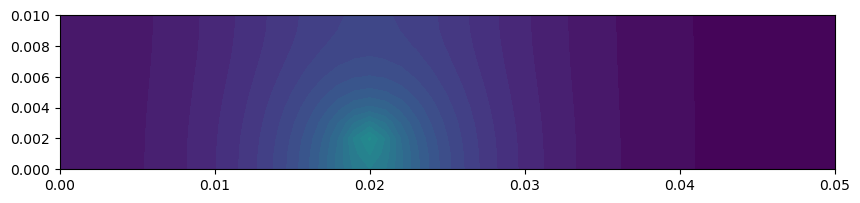

time step: 1.1  Temperature range  Summary: inf=0.0138683 sup=0.498401 data points=12801
time step: 1.2  Temperature range  Summary: inf=0.017666 sup=0.514519 data points=12801
time step: 1.3  Temperature range  Summary: inf=0.0219174 sup=0.530076 data points=12801
time step: 1.4  Temperature range  Summary: inf=0.0265973 sup=0.545157 data points=12801
time step: 1.5  Temperature range  Summary: inf=0.0316788 sup=0.559832 data points=12801
time step: 1.6  Temperature range  Summary: inf=0.037134 sup=0.574155 data points=12801
time step: 1.7  Temperature range  Summary: inf=0.0429358 sup=0.588175 data points=12801
time step: 1.8  Temperature range  Summary: inf=0.0490577 sup=0.601929 data points=12801


In [ ]:
from esys.escript import *
from esys.escript.linearPDEs import LinearPDE
from esys.finley import Rectangle
from scipy.interpolate import griddata
import numpy as np
from matplotlib import pyplot as plt

#... set some parameters ...
xc = [0.02, 0.002]         # centre of heat source
r = 0.001                  # radius of heat source
qc = 50.e6                 # strength of heat source
Tref = 0.                  # initial temperature
rhocp = 2.6e6              
eta = 75.
kappa = 240.               
tend = 5.                  # final time

# ... time, time step size and counter ...
t = 0.
h = 0.1
i = 0

#... generate domain ...
mydomain = Rectangle(l0=0.05, l1=0.01, n0=250, n1=50)

#... open PDE ...
mypde = LinearPDE(mydomain)
mypde.setSymmetryOn()
mypde.setValue(A=kappa*kronecker(mydomain), D=rhocp/h)
mypde.setValue(d=eta, y=eta*Tref)

# ... set heat source: ....
xy = mydomain.getX()
qH = qc*whereNegative(length(xy-xc)-r)

# ... set initial temperature ....
T=Tref

# gridding information for matplotlib
x_grid = np.linspace(0., 0.05, 51, endpoint=True)
y_grid = np.linspace(0., 0.01, 11, endpoint=True)
xt = xy[0].toListOfTuples()
yt = xy[1].toListOfTuples()

# ... start iteration:
while t<tend:
    i += 1
    t += h
    
    mypde.setValue(Y=qH+rhocp/h*T)
    T = mypde.getSolution()
    print("time step:",round(t,2), " Temperature range ",T)
    if i%10 ==0: 
        z = interpolate(T, xy.getFunctionSpace())
        #print(z)
        Tt = z.toListOfTuples()
        Tt_grid = griddata((xt,yt),Tt,(x_grid[None,:],y_grid[:,None]),'linear')
        plt.figure(figsize = (10,2))
        plt.contourf(x_grid, y_grid, Tt_grid, 20,vmin=0., vmax=1.)
        plt.show()
